Крок 1: Імпорт пакетів

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import set_config

set_config(display='diagram')  

from sklearn.metrics import mean_absolute_percentage_error



Крок 2: Завантаження даних

In [2]:
# Завантаження навчального та валідаційного наборів даних
train_data = pd.read_csv('../datasets/mod_04_hw_train_data.csv')
valid_data = pd.read_csv('../datasets/mod_04_hw_valid_data.csv')

Крок 3: Первинний дослідницький аналіз даних (EDA)

                 Name  Phone_Number  Experience Qualification University  \
0  Jennifer Hernandez  120-602-1220         3.0           Msc      Tier2   
1      Timothy Walker  840-675-8650         5.0           PhD      Tier2   
2         David Duran  556-293-8643         5.0           Msc      Tier2   
3       Gloria Ortega  463-559-7474         3.0           Bsc      Tier3   
4      Matthew Steele  968-091-7683         5.0           Bsc      Tier2   

     Role Cert Date_Of_Birth  Salary  
0     Mid  Yes    25/08/1972   98000  
1  Senior  Yes    03/12/2013  135500  
2  Senior  Yes    19/07/2002  123500  
3     Mid   No    19/02/1970   85000  
4  Senior  Yes    20/02/1970  111500  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-n

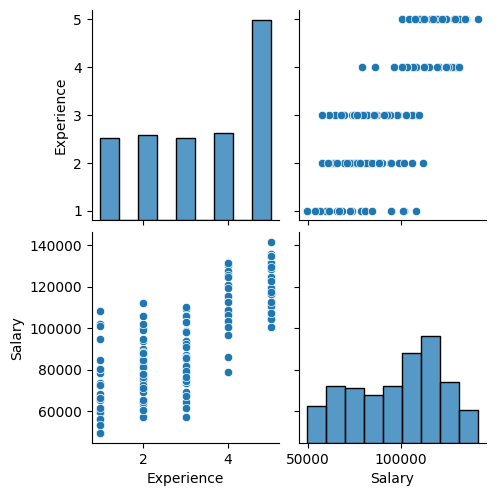

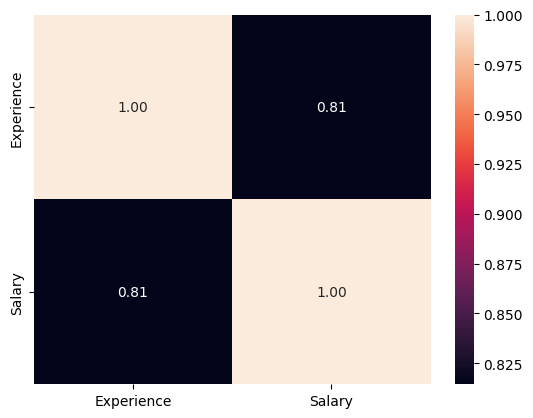

In [3]:
# Перегляд перших рядків тренувального набору даних
print(train_data.head())

# Отримання інформації про датасет
print(train_data.info())

# Статистичний огляд даних
print(train_data.describe())

# Перевірка на наявність пропущених значень
print(train_data.isnull().sum())

# Візуалізація розподілу змінних
sns.pairplot(train_data)
plt.show()

# Відбір лише числових колонок
numerical_data = train_data.select_dtypes(include=[np.number])

# Кореляційна матриця для числових змінних
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f")
plt.show()



Крок 4: Перевірка і очищення даних

In [4]:
from scipy import stats

# Виділення числових даних для аналізу
numerical_data = train_data.select_dtypes(include=[np.number])

# Обрахунок Z-оцінки для числових колонок
z_scores = np.abs(stats.zscore(numerical_data))

# Видалення рядків, де будь-яка числова колонка має Z-оцінку більше 3
filtered_data = numerical_data[(z_scores < 3).all(axis=1)]

# Відображення кількості видалених рядків з викидами
print("Видалено рядків з викидами:", numerical_data.shape[0] - filtered_data.shape[0])

# Створення копії датафрейму для безпечної модифікації
filtered_data = filtered_data.copy()

# Заповнення пропущених значень медіаною для кожної колонки
filtered_data = filtered_data.fillna(filtered_data.median())

# Перевірка пропущених значень після обробки
print(filtered_data.isnull().sum())

Видалено рядків з викидами: 249
Experience    0
Salary        0
dtype: int64


Крок 5: Кодування категоріальних ознак та нормалізація числових ознак

In [5]:

# Виділення категоріальних і числових ознак
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Salary')  # Видалення цільової змінної

# Створення пайплайнів для обробки ознак
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заповнення пропусків медіаною
    ('scaler', StandardScaler())                    # Нормалізація даних
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Заповнення пропусків
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # One-hot кодування
])

# Об'єднання трансформерів у колонковий трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Крок 6: Побудова та навчання моделі KNeighborsRegressor

In [6]:
# Створення пайплайну з моделлю
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=3))  # Використання 3 найближчих сусідів
])

# Розділення даних на ознаки і цільову змінну
X_train = train_data.drop('Salary', axis=1)
y_train = train_data['Salary']

# Навчання моделі
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Experience']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Phone_Number',
                                                   'Qualification',
                                                   'University', 'Role', 'Cert',
                                                   'Date_Of_Birth'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=3))])

Крок 7: Оцінка моделі

In [8]:
# Оцінка моделі на валідаційному наборі
X_valid = valid_data.drop('Salary', axis=1)
y_valid = valid_data['Salary']
y_pred = model_pipeline.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)


# Передбачення за допомогою моделі
y_pred = model_pipeline.predict(X_valid)  

# Обчислення MAPE
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f'Validation MAPE: {mape:.2%}')

print("Середньоквадратична помилка на валідаційному наборі:", mse)


Validation MAPE: 8.86%
Середньоквадратична помилка на валідаційному наборі: 97288730.15873016


модель не дає потрібний результат.